# 7.b. Implementing our first Shallow Neural Network in Numpy - Back Propagation

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.2 (15/06/2023)

**Requirements:**
- Python 3 (tested on v3.11.4)
- Matplotlib (tested on v3.7.1)
- Numpy (tested on v1.24.3)
- Sklearn (tested on v0.0.post5)

### Imports

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
# Numpy
import numpy as np
# Removing unecessary warnings (optional, just makes notebook outputs more readable)
import warnings
warnings.filterwarnings("ignore")

### Mock dataset generation

As in Notebook 7.a.

In [2]:
# All helper functions
min_surf = 40
max_surf = 200
def surface(min_surf, max_surf):
    return round(np.random.uniform(min_surf, max_surf), 2)
min_dist = 50
max_dist = 1000
def distance(min_dist, max_dist):
    return round(np.random.uniform(min_dist, max_dist), 2)
def price(surface, distance):
    return round((100000 + 14373*surface + (1000 - distance)*1286)*(1 + np.random.uniform(-0.1, 0.1)))/1000000
n_points = 100
def create_dataset(n_points, min_surf, max_surf, min_dist, max_dist):
    surfaces_list = np.array([surface(min_surf, max_surf) for _ in range(n_points)])
    distances_list = np.array([distance(min_dist, max_dist) for _ in range(n_points)])
    inputs = np.array([[s, d] for s, d in zip(surfaces_list, distances_list)])
    outputs = np.array([price(s, d) for s, d in zip(surfaces_list, distances_list)]).reshape(n_points, 1)
    return surfaces_list, distances_list, inputs, outputs

In [3]:
# Generate dataset
np.random.seed(47)
surfaces_list, distances_list, inputs, outputs = create_dataset(n_points, min_surf, max_surf, min_dist, max_dist)
# Check a few entries of the dataset
print(surfaces_list.shape)
print(distances_list.shape)
print(inputs.shape)
print(outputs.shape)
print(inputs[0:10, :])
print(outputs[0:10])

(100,)
(100,)
(100, 2)
(100, 1)
[[ 58.16 572.97]
 [195.92 809.8 ]
 [156.6  349.04]
 [ 96.23  86.82]
 [153.22 817.92]
 [167.94 806.25]
 [143.29 315.92]
 [106.34 482.67]
 [152.96 427.77]
 [ 79.46 955.76]]
[[1.581913]
 [3.450274]
 [2.978769]
 [2.808258]
 [2.556398]
 [3.023983]
 [3.099523]
 [2.121069]
 [3.136544]
 [1.273443]]


### Defining a Neural Network class, with a single hidden layer

As in Notebook 7.a., we will reuse the ShallowNeuralNet class we defined earlier, along with its forward and loss methods.

In [4]:
class ShallowNeuralNet():
    
    def __init__(self, n_x, n_h, n_y):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Weights and biases matrices
        self.W1 = np.random.randn(n_x, n_h)*0.1
        self.b1 = np.random.randn(1, n_h)*0.1
        self.W2 = np.random.randn(n_h, n_y)*0.1
        self.b2 = np.random.randn(1, n_y)*0.1
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
        
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        # Wx + b operation for the second layer
        Z2 = np.matmul(Z1_b, self.W2)
        Z2_b = Z2 + self.b2
        return Z2_b
    
    def MSE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        losses = (pred - outputs_re)**2
        self.loss = np.sum(losses)/outputs.shape[0]
        return self.loss

Then we can try it on our dataset, by using $ n_x = 2 $ and $ n_y = 1 $ to match the dimensionality of our dataset. The hidden layer size $ n_h $ is free for us to choose, and we will arbitrarily fix it to 4.

In [5]:
# Define neural network structure
n_x = 2
n_h = 4
n_y = 1
np.random.seed(27)
shallow_neural_net = ShallowNeuralNet(n_x, n_h, n_y)
print(shallow_neural_net.__dict__)

{'n_x': 2, 'n_h': 4, 'n_y': 1, 'W1': array([[ 0.12856054, -0.03035534,  0.06190757,  0.03959985],
       [ 0.02234056, -0.00543394, -0.01792763,  0.0242832 ]]), 'b1': array([[0.08210565, 0.12170537, 0.05594487, 0.03767429]]), 'W2': array([[-0.05611392],
       [-0.10076837],
       [ 0.12261832],
       [-0.05304565]]), 'b2': array([[-0.02754831]]), 'loss': inf}


At the moment, the neural network is poorly predicting, as the values used in the $ W $ and $ b $ matrices of each layer have been randomly decided.

In [6]:
pred = shallow_neural_net.forward(inputs)
print(pred.shape)
print(outputs.shape)
print(pred[0:5])
print(outputs[0:5])

(100, 1)
(100, 1)
[[-2.36403331]
 [-3.17298402]
 [-1.29378492]
 [-0.27505565]
 [-3.26404055]]
[[1.581913]
 [3.450274]
 [2.978769]
 [2.808258]
 [2.556398]]


This also becomes apparent when checking the loss function for this model. As a comparison, our first simple model has a loss of roughly 0.025!

In [7]:
loss = shallow_neural_net.MSE_loss(inputs, outputs)
print(loss)

22.32154068107234


### Implementing a back propagation mechanism

Of course, the poor prediction of the model above has to do with the fact that we could not smartly set the weights like before, and that the random initialization for our shallow neural network was incorrect.

Now, of course, we are not going to randomly try our luck and pray to the RNG (Random Number Generation) gods for a lucky initialization on the $ W $ and $ b $ matrices... Instead, we will tell our model how to adjust the said matrices to improve its loss and prediction capabilities.

This process is called, **back propagation** and will be implemented in the **backward()** method of our model.

Backpropagation is an algorithm used to train neural networks, including shallow neural networks with no activation functions. It is a type of gradient descent algorithm that allows the network to learn by adjusting the weights of the connections between the neurons in the network.

Remember that our objective is find the weigths and bias matrices, which will minimize the loss function $ L $

$$ W_1^*, b_1^*, W_2^*, b_2^* = \arg \min_{W_1, b_1, W_2, b_2} \left[ L(x, y, W_1, b_1, W_2, b_2) \right] = \arg \min_{W_1, b_1, W_2, b_2} \left[ \frac{1}{M} (y_{pred}(x, W_1, b_1, W_2, b_2) - y)^2 \right]. $$

Here, $ y_{pred}(x, W_1, b_1, W_2, b_2) $ refers to the prediction formulated by the neural network, which consists of two $ WX + b $ operations in sequence, as defined in the **forward** method. More specifically, we have:

$$ y_{pred}(x, W_1, b_1, W_2, b_2) = W_2 \left( W_1 x + b_1 \right) + b_2. $$

The optimization problem above then becomes

$$ W_1^*, b_1^*, W_2^*, b_2^* = \arg \min_{W_1, b_1, W_2, b_2} \left[ \left( W_2 \left( W_1 x + b_1 \right) + b_2 - y \right)^2  \right]. $$

For this optimization problem, we can write a gradient descent update rule for all four matrices $ W_1 $ , $ b_1 $, $ W_2 $ and $ b_2 $.

As a recap, here are the five step required for our backpropagation method:
- The input data is fed through the neural network, and a prediction is formulated by the neural network.
- The prediction is compared to the desired output from the dataset, and an error term is calculated using a loss function. The error term $ \epsilon $ is then simply defined as

$$ \begin{array}{ll} \epsilon &= y_{pred}(x, W_1, b_1, W_2, b_2) - y \\ & = W_2 \left( W_1 x + b_1 \right) + b_2 - y. \end{array} $$

- This error is then propagated back through the network, and the weights of the connections are adjusted to reduce the error. Typically, we can start first by calculating the gradient of the loss function with respect to the weights in the second layer (w2 and b2) by using the chain rule. We have:

$$ \frac{\partial L(x, y, W_1, b_1, W_2, b_2)}{\partial W_2} = \frac{\partial L(x, y, W_1, b_1, W_2, b_2)}{\partial y_{pred}} . \frac{\partial y_{pred}}{\partial W_2}. $$

Followig the MSE definition and the $ y_{pred} $ formula above, we have:

$$ \frac{\partial L(x, y, W_1, b_1, W_2, b_2)}{\partial y_{pred}} = \frac{2}{M} (y_{pred}(x, W_1, b_1, W_2, b_2) - y) = \frac{2}{M} \epsilon $$

And

$$ \frac{\partial y_{pred}}{\partial W_2} = \left( W_1 x + b_1 \right). $$

This gives the following value for the derivative $ \frac{\partial L(x, y, W_1, b_1, W_2, b_2)}{\partial W_2} $, along with the gradient descent update rule for $ W_2 $:

$$ \frac{\partial L(x, y, W_1, b_1, W_2, b_2)}{\partial W_2} = \frac{2}{M} \epsilon \left( W_1 x + b_1 \right) $$

$$ W_2 \leftarrow W_2 - \frac{2}{M} \alpha \epsilon \left( W_1 x + b_1 \right) $$

With $ \alpha $ denoting the gradient descent learning rate.

Similarly, we can calculate the value for the derivative $ \frac{\partial L(x, y, W_1, b_1, W_2, b_2)}{\partial b_2} $, along with the gradient descent update rule for $ b_2 $:

$$ \frac{\partial L(x, y, W_1, b_1, W_2, b_2)}{\partial b_2} = \frac{2}{M} \epsilon $$

$$ b_2 \leftarrow b_2 - \frac{2}{M} \alpha \epsilon $$

These two rules allow to update the value of the weight matrix $ W_2 $ and the bias matrix $ b_2 $ of the last processing layer. We then need to backpropagate once more, to define the update rules of the weight matrix $ W_1 $ and the bias matrix $ b_1 $ for the first layer. The same idea, reyling on the chain rule from earlier is used.

Here, we can use the following chain rules:

$$ \frac{\partial L(x, y, W_1, b_1, W_2, b_2)}{\partial W_1} = \frac{\partial L(x, y, W_1, b_1, W_2, b_2)}{\partial y_{pred}} . \frac{\partial y_{pred}}{\partial W_1}, $$

$$ \frac{\partial L(x, y, W_1, b_1, W_2, b_2)}{\partial b_1} = \frac{\partial L(x, y, W_1, b_1, W_2, b_2)}{\partial y_{pred}} . \frac{\partial y_{pred}}{\partial b_1}. $$

We then obtain the following gradient descent update rules:

$$ W_1 \leftarrow W_1 - \frac{2}{M} \alpha \epsilon W_2 x $$

$$ b_1 \leftarrow b_1 - \frac{2}{M} \alpha \epsilon W_2 $$

Let us implement them in the class below.

In [8]:
class ShallowNeuralNet():
    
    def __init__(self, n_x, n_h, n_y):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Weights and biases matrices
        self.W1 = np.random.randn(n_x, n_h)*0.1
        self.b1 = np.random.randn(1, n_h)*0.1
        self.W2 = np.random.randn(n_h, n_y)*0.1
        self.b2 = np.random.randn(1, n_y)*0.1
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
        
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        # Wx + b operation for the second layer
        Z2 = np.matmul(Z1_b, self.W2)
        Z2_b = Z2 + self.b2
        return Z2_b
    
    def MSE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        losses = (pred - outputs_re)**2
        self.loss = np.sum(losses)/outputs.shape[0]
        return self.loss
    
    def backward(self, inputs, outputs, alpha = 1e-5):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        Z2 = np.matmul(Z1_b, self.W2)
        y_pred = Z2 + self.b2
        
        # Compute error term
        epsilon = y_pred - outputs
        
        # Compute the gradient for W2 and b2
        dL_dW2 = (2/m)*np.matmul(Z1_b.T, epsilon)
        dL_db2 = (2/m)*np.sum(epsilon, axis = 0, keepdims = True)
        
        # Compute the loss derivative with respect to the first layer
        dL_dZ1 = np.matmul(epsilon, self.W2.T)
        
        # Compute the gradient for W1 and b1
        dL_dW1 = (2/m)*np.matmul(inputs.T, dL_dZ1)
        dL_db1 = (2/m)*np.sum(dL_dZ1, axis = 0, keepdims = True)
        
        # Update the weights and biases using gradient descent
        self.W1 -= alpha*dL_dW1
        self.b1 -= alpha*dL_db1
        self.W2 -= alpha*dL_dW2
        self.b2 -= alpha*dL_db2
        
        # Update loss
        self.MSE_loss(inputs, outputs)

### Visualizing the effect of backpropagation

If we now try our backpropagation method, we will see that the weights are getting adjusted and it eventually leads to an improvement in the loss function for our model, after each call of the **backward()**.

In [9]:
# Define neural network structure
n_x = 2
n_h = 4
n_y = 1
np.random.seed(967)
shallow_neural_net = ShallowNeuralNet(n_x, n_h, n_y)
loss = shallow_neural_net.MSE_loss(inputs, outputs)
print(shallow_neural_net.loss)

13.1869714693353


In [10]:
shallow_neural_net.backward(inputs, outputs, 1e-5)
print(shallow_neural_net.loss)

8.576174190387835


In [11]:
shallow_neural_net.backward(inputs, outputs, 1e-5)
print(shallow_neural_net.loss)

5.818528741557871


In [12]:
shallow_neural_net.backward(inputs, outputs, 1e-5)
print(shallow_neural_net.loss)

4.14790610131927


### Defining a trainer for our neural network

Our objective is now to repeat the back propagation until we observe a convergence on the loss function. We we get to that point, that means the values in $ W_1 $, $ b_1 $, $ W_2 $ and $ b_2 $ are close to the optimal values.

Typically, we want to repeat this operation until
- a maximal number of iterations $ N_{max} $ is reached, 
- or the value of the loss function before and after the back propagation has changed by less than a certain value $ \beta $.

We implement these iterations below.
In addition, we will assemble the values of the loss function after each **backward()** method call in a list for visualization later. Let us start with an untrained neural network, uncapable of predicting prices correctly.

In [13]:
# Define neural network structure
n_x = 2
n_h = 4
n_y = 1
np.random.seed(37)
shallow_neural_net = ShallowNeuralNet(n_x, n_h, n_y)
loss = shallow_neural_net.MSE_loss(inputs, outputs)
print(shallow_neural_net.loss)

6.901103878736592


In [14]:
pred = shallow_neural_net.forward(inputs)
print(pred.shape)
print(outputs.shape)
print(pred[0:5])
print(outputs[0:5])

(100, 1)
(100, 1)
[[4.05690935]
 [5.50963289]
 [2.35780791]
 [0.61816999]
 [5.62693952]]
[[1.581913]
 [3.450274]
 [2.978769]
 [2.808258]
 [2.556398]]


In [15]:
# Our trainer function
def train(shallow_neural_net, inputs, outputs, N_max = 1000, \
          alpha = 1e-5, delta = 1e-5, display = True):
    # List of losses, starts with the current loss
    losses_list = [shallow_neural_net.loss]
    # Repeat iterations
    for iteration_number in range(1, N_max + 1):
        # Backpropagate
        shallow_neural_net.backward(inputs, outputs, alpha)
        new_loss = shallow_neural_net.loss
        # Update losses list
        losses_list.append(new_loss)
        # Display
        if(display):
            print("Iteration {} - Loss = {}".format(iteration_number, new_loss))
        # Check for delta value and early stop criterion
        difference = abs(losses_list[-1] - losses_list[-2])
        if(difference < delta):
            if(display):
                print("Stopping early - loss evolution was less than delta.")
            break
    else:
        # Else on for loop will execute if break did not trigger
        if(display):
            print("Stopping - Maximal number of iterations reached.")
    return losses_list

We can now use our trainer function and see how the loss functions decreases, eventually converging around 0.164.

In [16]:
losses_list = train(shallow_neural_net, inputs, outputs, N_max = 10000, alpha = 1e-5, delta = 1e-6, display = True)

Iteration 1 - Loss = 4.639845655363769
Iteration 2 - Loss = 3.6055739235388646
Iteration 3 - Loss = 3.1219544752264055
Iteration 4 - Loss = 2.891370725402625
Iteration 5 - Loss = 2.778663798354082
Iteration 6 - Loss = 2.721333641596964
Iteration 7 - Loss = 2.6901646643755135
Iteration 8 - Loss = 2.671407441095785
Iteration 9 - Loss = 2.6585626629544303
Iteration 10 - Loss = 2.648548914291606
Iteration 11 - Loss = 2.639902127093024
Iteration 12 - Loss = 2.6319255476288577
Iteration 13 - Loss = 2.6242871305644138
Iteration 14 - Loss = 2.6168284145839156
Iteration 15 - Loss = 2.60947364178999
Iteration 16 - Loss = 2.6021864900028118
Iteration 17 - Loss = 2.5949494536811937
Iteration 18 - Loss = 2.58775401064343
Iteration 19 - Loss = 2.5805959297914653
Iteration 20 - Loss = 2.573473031003096
Iteration 21 - Loss = 2.5663841153306994
Iteration 22 - Loss = 2.5593284539867067
Iteration 23 - Loss = 2.5523055442254163
Iteration 24 - Loss = 2.5453149927332275
Iteration 25 - Loss = 2.5383564599410

Iteration 1275 - Loss = 0.16966111424487237
Iteration 1276 - Loss = 0.16962495162870092
Iteration 1277 - Loss = 0.16958903973218217
Iteration 1278 - Loss = 0.16955337685661542
Iteration 1279 - Loss = 0.1695179613141019
Iteration 1280 - Loss = 0.16948279142748285
Iteration 1281 - Loss = 0.16944786553027855
Iteration 1282 - Loss = 0.16941318196662908
Iteration 1283 - Loss = 0.16937873909123244
Iteration 1284 - Loss = 0.16934453526928522
Iteration 1285 - Loss = 0.16931056887642223
Iteration 1286 - Loss = 0.16927683829865817
Iteration 1287 - Loss = 0.16924334193232615
Iteration 1288 - Loss = 0.16921007818402115
Iteration 1289 - Loss = 0.16917704547053927
Iteration 1290 - Loss = 0.1691442422188203
Iteration 1291 - Loss = 0.1691116668658893
Iteration 1292 - Loss = 0.16907931785879804
Iteration 1293 - Loss = 0.16904719365456838
Iteration 1294 - Loss = 0.16901529272013321
Iteration 1295 - Loss = 0.1689836135322809
Iteration 1296 - Loss = 0.16895215457759757
Iteration 1297 - Loss = 0.1689209143

Iteration 1821 - Loss = 0.1645096674302069
Iteration 1822 - Loss = 0.16450848241505306
Iteration 1823 - Loss = 0.16450730219360452
Iteration 1824 - Loss = 0.16450612673012774
Iteration 1825 - Loss = 0.16450495598915466
Iteration 1826 - Loss = 0.16450378993547954
Iteration 1827 - Loss = 0.16450262853415776
Iteration 1828 - Loss = 0.164501471750503
Iteration 1829 - Loss = 0.16450031955008648
Iteration 1830 - Loss = 0.16449917189873392
Iteration 1831 - Loss = 0.16449802876252473
Iteration 1832 - Loss = 0.16449689010778965
Iteration 1833 - Loss = 0.16449575590110846
Iteration 1834 - Loss = 0.1644946261093091
Iteration 1835 - Loss = 0.1644935006994652
Iteration 1836 - Loss = 0.1644923796388943
Iteration 1837 - Loss = 0.1644912628951564
Iteration 1838 - Loss = 0.1644901504360516
Iteration 1839 - Loss = 0.16448904222961955
Iteration 1840 - Loss = 0.1644879382441361
Iteration 1841 - Loss = 0.16448683844811257
Iteration 1842 - Loss = 0.1644857428102939
Iteration 1843 - Loss = 0.1644846512996565

In this current configuration, the model is now better at predicting!

In [17]:
pred = shallow_neural_net.forward(inputs)
print(pred.shape)
print(outputs.shape)
print(pred[0:5])
print(outputs[0:5])

(100, 1)
(100, 1)
[[0.96041681]
 [3.7237574 ]
 [3.2215921 ]
 [2.12610054]
 [2.80781243]]
[[1.581913]
 [3.450274]
 [2.978769]
 [2.808258]
 [2.556398]]


We can also display the evolution of the losses during the training, in both decimal and logarithmic scale. These are called **training curves** and can be used to see that the loss has decreased and has converged to a value.

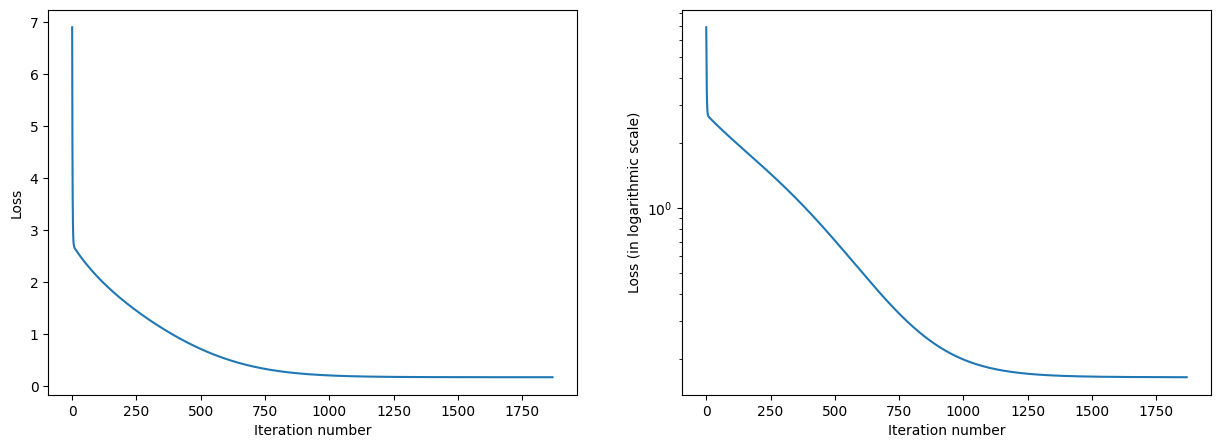

In [18]:
# Initialize matplotlib
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
axs[0].plot(list(range(len(losses_list))), losses_list)
axs[0].set_xlabel("Iteration number")
axs[0].set_ylabel("Loss")
axs[1].plot(list(range(len(losses_list))), losses_list)
axs[1].set_xlabel("Iteration number")
axs[1].set_ylabel("Loss (in logarithmic scale)")
axs[1].set_yscale("log")
# Display
plt.show()

We will let the reader experiment with different values of seeds (for initializing the weights of the neural network), as well as different values of $ N_{max} $, $ \alpha $ and $ \delta $.

### Adding a trainer method to our ShallowNeuralNet class

For now, we will conclude this notebook by integrating the trainer function and the display as their own methods for our class, as shown below.

In [19]:
class ShallowNeuralNet():
    
    def __init__(self, n_x, n_h, n_y):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Weights and biases matrices
        self.W1 = np.random.randn(n_x, n_h)*0.1
        self.b1 = np.random.randn(1, n_h)*0.1
        self.W2 = np.random.randn(n_h, n_y)*0.1
        self.b2 = np.random.randn(1, n_y)*0.1
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
        
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        # Wx + b operation for the second layer
        Z2 = np.matmul(Z1_b, self.W2)
        Z2_b = Z2 + self.b2
        return Z2_b
    
    def MSE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        losses = (pred - outputs_re)**2
        self.loss = np.sum(losses)/outputs.shape[0]
        return self.loss
    
    def backward(self, inputs, outputs, alpha = 1e-5):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        Z2 = np.matmul(Z1_b, self.W2)
        y_pred = Z2 + self.b2
    
        # Compute error term
        epsilon = y_pred - outputs
    
        # Compute the gradient for W2 and b2
        dL_dW2 = (2/m)*np.matmul(Z1_b.T, epsilon)
        dL_db2 = (2/m)*np.sum(epsilon, axis = 0, keepdims = True)

        # Compute the loss derivative with respect to the first layer
        dL_dZ1 = np.matmul(epsilon, self.W2.T)

        # Compute the gradient for W1 and b1
        dL_dW1 = (2/m)*np.matmul(inputs.T, dL_dZ1)
        dL_db1 = (2/m)*np.sum(dL_dZ1, axis = 0, keepdims = True)

        # Update the weights and biases using gradient descent
        self.W1 -= alpha*dL_dW1
        self.b1 -= alpha*dL_db1
        self.W2 -= alpha*dL_dW2
        self.b2 -= alpha*dL_db2
        
        # Update loss
        self.MSE_loss(inputs, outputs)
    
    def train(self, inputs, outputs, N_max = 1000, alpha = 1e-5, delta = 1e-5, display = True):
        # List of losses, starts with the current loss
        self.losses_list = [self.loss]
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Backpropagate
            self.backward(inputs, outputs, alpha)
            new_loss = self.loss
            # Update losses list
            self.losses_list.append(new_loss)
            # Display
            if(display):
                print("Iteration {} - Loss = {}".format(iteration_number, new_loss))
            # Check for delta value and early stop criterion
            difference = abs(self.losses_list[-1] - self.losses_list[-2])
            if(difference < delta):
                if(display):
                    print("Stopping early - loss evolution was less than delta.")
                break
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
    
    def show_losses_over_training(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))
        axs[0].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Loss")
        axs[1].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Loss (in logarithmic scale)")
        axs[1].set_yscale("log")
        # Display
        plt.show()

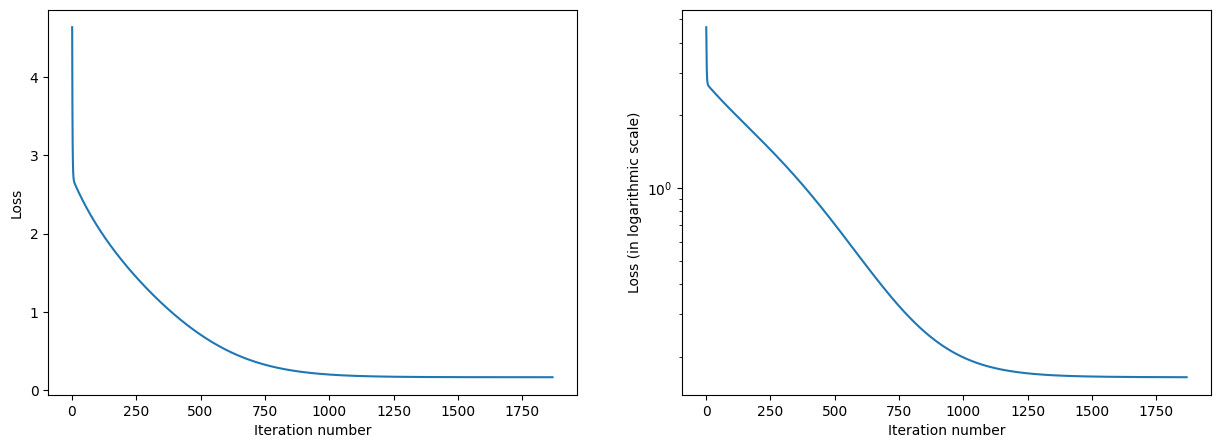

In [20]:
# Define neural network structure
n_x = 2
n_h = 4
n_y = 1
np.random.seed(37)
shallow_neural_net = ShallowNeuralNet(n_x, n_h, n_y)
shallow_neural_net.train(inputs, outputs, N_max = 10000, alpha = 1e-5, delta = 1e-6, display = False)
shallow_neural_net.show_losses_over_training()

### What's next?

In the future notebook, we will reuse this ShallowNeuralNetwork model and integrate some variations to help with the training of our model. Typically, we will investigate activation functions, different initializations, some variations of the gradient descent algorithm, etc.